In [1]:
import os
import pickle
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.cm as cm
import matplotlib.mlab as mlab 
from collections import namedtuple


In [2]:
class Args():
    def __init__(self) -> None:
        pass

args = Args()

In [3]:

def sample(e, mu1, mu2, std1, std2, rho):
    cov = np.array([[std1 * std1, std1 * std2 * rho],
                    [std1 * std2 * rho, std2 * std2]])
    mean = np.array([mu1, mu2])

    x, y = np.random.multivariate_normal(mean, cov)
    end = np.random.binomial(1, e)
    return np.array([x, y, end])

In [4]:
def split_strokes(points):
    points = np.array(points)
    strokes = []
    b = 0
    for e in range(len(points)):
        if points[e, 2] == 1.:
            strokes += [points[b: e + 1, :2].copy()]
            b = e + 1
    return strokes


In [5]:
def cumsum(points):
    sums = np.cumsum(points[:, :2], axis=0)
    return np.concatenate([sums, points[:, 2:]], axis=1)


In [6]:

def sample_text(sess, args_text, translation, style=None):
    fields = ['coordinates', 'sequence', 'bias', 'e', 'pi', 'mu1', 'mu2', 'std1', 'std2',
              'rho', 'window', 'kappa', 'phi', 'finish', 'zero_states']
    vs = namedtuple('Params', fields)(
        *[tf.compat.v1.get_collection(name)[0] for name in fields]
    )

    text = np.array([translation.get(c, 0) for c in args_text])
    coord = np.array([0., 0., 1.])
    coords = [coord]

    # Prime the model with the author style if requested
    prime_len, style_len = 0, 0
    if style is not None:
        # Priming consist of joining to a real pen-position and character sequences the synthetic sequence to generate
        #   and set the synthetic pen-position to a null vector (the positions are sampled from the MDN)
        style_coords, style_text = style
        prime_len = len(style_coords)
        style_len = len(style_text)
        prime_coords = list(style_coords)
        coord = prime_coords[0] # Set the first pen stroke as the first element to process
        text = np.r_[style_text, text] # concatenate on 1 axis the prime text + synthesis character sequence
        sequence_prime = np.eye(len(translation), dtype=np.float32)[style_text]
        sequence_prime = np.expand_dims(np.concatenate([sequence_prime, np.zeros((1, len(translation)))]), axis=0)

    sequence = np.eye(len(translation), dtype=np.float32)[text]
    sequence = np.expand_dims(np.concatenate([sequence, np.zeros((1, len(translation)))]), axis=0)

    phi_data, window_data, kappa_data, stroke_data = [], [], [], []
    sess.run(vs.zero_states)
    sequence_len = len(args_text) + style_len
    for s in range(1, 60 * sequence_len + 1):
        is_priming = s < prime_len

        print('\r[{:5d}] sampling... {}'.format(s, 'priming' if is_priming else 'synthesis'), end='')

        e, pi, mu1, mu2, std1, std2, rho, \
        finish, phi, window, kappa = sess.run([vs.e, vs.pi, vs.mu1, vs.mu2,
                                               vs.std1, vs.std2, vs.rho, vs.finish,
                                               vs.phi, vs.window, vs.kappa],
                                              feed_dict={
                                                  vs.coordinates: coord[None, None, ...],
                                                  vs.sequence: sequence_prime if is_priming else sequence,
                                                  vs.bias: args.bias
                                              })

        if is_priming:
            # Use the real coordinate if priming
            coord = prime_coords[s]
        else:
            # Synthesis mode
            phi_data += [phi[0, :]]
            window_data += [window[0, :]]
            kappa_data += [kappa[0, :]]
            # ---
            g = np.random.choice(np.arange(pi.shape[1]), p=pi[0])
            coord = sample(e[0, 0], mu1[0, g], mu2[0, g],
                           std1[0, g], std2[0, g], rho[0, g])
            coords += [coord]
            stroke_data += [[mu1[0, g], mu2[0, g], std1[0, g], std2[0, g], rho[0, g], coord[2]]]

            if not args.force and finish[0, 0] > 0.8:
                print('Finished sampling!\n')
                break

    coords = np.array(coords)
    coords[-1, 2] = 1.

    return phi_data, window_data, kappa_data, stroke_data, coords



In [7]:
def gen(text, w_style, w_bias, info, output):
    my_path = os.getcwd()
    
    with open(os.path.join('data', 'translation.pkl'), 'rb') as file:
        translation = pickle.load(file)
    rev_translation = {v: k for k, v in translation.items()}
    charset = [rev_translation[i] for i in range(len(rev_translation))]
    charset[0] = ''
    info = False
    config = tf.compat.v1.ConfigProto(
        device_count={'GPU': 0}
    )
    with tf.compat.v1.Session(config=config) as sess:
        saver = tf.compat.v1.train.import_meta_graph(args.model_path + '.meta')
        saver.restore(sess, args.model_path)

        """
        while True:
            
            if args.text is not None:
                args_text = args.text
            else:
                args_text = input('What to generate: ')
        """
        style = None
        w_style = int(w_style)
        args.bias = w_bias
        if w_style != 404:
            args.style = w_style
        if args.style is not None:
            style = None
            with open(os.path.join('data', 'styles.pkl'), 'rb') as file:
                styles = pickle.load(file)

            if args.style > len(styles[0]):
                raise ValueError('Requested style is not in style list')

            style = [styles[0][args.style], styles[1][args.style]]

        text_file = text

        textinput = []

        for line in text_file:
            textinput.append(line)

        nooflines = len(textinput)
        i = 0

        plt.figure(figsize=(24, 24))
        fig,ax = plt.subplots(nooflines)

        for line in textinput:
            print("Line = ", line)
            args_text= line
            phi_data, window_data, kappa_data, stroke_data, coords = sample_text(sess, args_text, translation, style)

            strokes = np.array(stroke_data)
            epsilon = 1e-8
            strokes[:, :2] = np.cumsum(strokes[:, :2], axis=0)

            for stroke in split_strokes(cumsum(np.array(coords))):
                ax[i].plot(stroke[:, 0], -stroke[:, 1], color="black")
            ax[i].set_title(args_text)
            ax[i].set_aspect('equal')
            i+=1
                
            
        
        print("Saving image to: ", os.path.join(my_path,'images','multiLine' , output))
        plt.savefig(os.path.join(my_path,'images','multiLine', output))
        plt.show()


bias =  1.0
INFO:tensorflow:Restoring parameters from trained_models\model-29
Line =  Machine Learning 

[ 1424] sampling... synthesisFinished sampling!

Line =  Handwriting Generation
[ 2045] sampling... synthesisFinished sampling!

Saving image to:  d:\ml-project-final\Machine-Learning-Project\images\multiLine\test100.png


<Figure size 1728x1728 with 0 Axes>

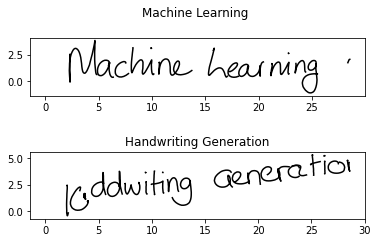

bias =  0.7
INFO:tensorflow:Restoring parameters from trained_models\model-29
Line =  Machine Learning 

[ 1484] sampling... synthesisFinished sampling!

Line =  Handwriting Generation
[ 1643] sampling... synthesisFinished sampling!

Saving image to:  d:\ml-project-final\Machine-Learning-Project\images\multiLine\test70.png


<Figure size 1728x1728 with 0 Axes>

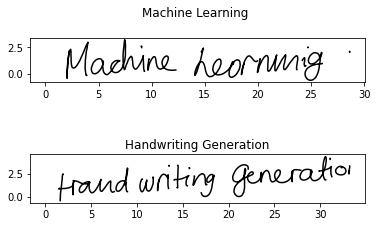

bias =  0.3
INFO:tensorflow:Restoring parameters from trained_models\model-29
Line =  Machine Learning 

[ 1384] sampling... synthesisFinished sampling!

Line =  Handwriting Generation
[ 1622] sampling... synthesisFinished sampling!

Saving image to:  d:\ml-project-final\Machine-Learning-Project\images\multiLine\test30.png


<Figure size 1728x1728 with 0 Axes>

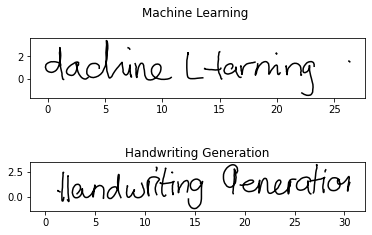

bias =  0
INFO:tensorflow:Restoring parameters from trained_models\model-29
Line =  Machine Learning 

[ 1391] sampling... synthesisFinished sampling!

Line =  Handwriting Generation
[ 1543] sampling... synthesisFinished sampling!

Saving image to:  d:\ml-project-final\Machine-Learning-Project\images\multiLine\test0.png


<Figure size 1728x1728 with 0 Axes>

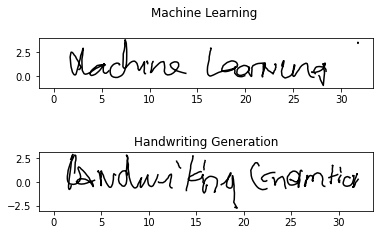

In [8]:
args.model_path = os.path.join('trained_models', 'model-29')
args.text = "test.txt"
args.style = 0
args.info = False
args.force = False


biases = [1.0, 0.7, 0.3, 0]
names = ["100", "70", "30", "0"]

for i in range(len(biases)):
    args.bias=biases[i]
    args.output = "test" + names[i] +".png"
    text = open(args.text)
    print("bias = ", args.bias)
    gen(text, args.style, args.bias, args.info, args.output)
    text.close()



bias =  1.0
INFO:tensorflow:Restoring parameters from trained_models\model-29
Line =  Pranava Raman B  M  S

[ 1015] sampling... synthesisFinished sampling!

Line =  Preeti Krishnaveni Ra

[ 1573] sampling... synthesisFinished sampling!

Line =  Anu sree V
[  715] sampling... synthesisFinished sampling!

Saving image to:  d:\ml-project-final\Machine-Learning-Project\images\multiLine\signature100.png


<Figure size 1728x1728 with 0 Axes>

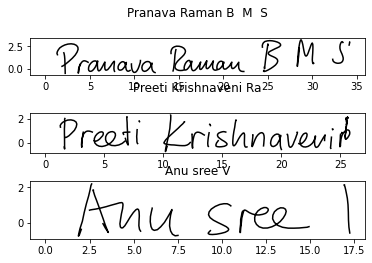

In [55]:
args.model_path = os.path.join('trained_models', 'model-29')
args.text = "sign.txt"
args.style = 4
args.info = False
args.force = False


biases = [1.0]
names = ["100"]

for i in range(len(biases)):
    args.bias=biases[i]
    args.output = "signature" + names[i] +".png"
    text = open(args.text)
    print("bias = ", args.bias)
    gen(text, args.style, args.bias, args.info, args.output)
    text.close()


bias =  1.0
INFO:tensorflow:Restoring parameters from trained_models\model-29
Line =  Pranava Raman B  M  S

[ 1492] sampling... synthesisFinished sampling!

Line =  Preeti Krishnaveni Ra

[ 1588] sampling... synthesisFinished sampling!

Line =  Anu sree V
[ 1107] sampling... synthesisFinished sampling!

Saving image to:  d:\ml-project-final\Machine-Learning-Project\images\multiLine\signature100.png


<Figure size 1728x1728 with 0 Axes>

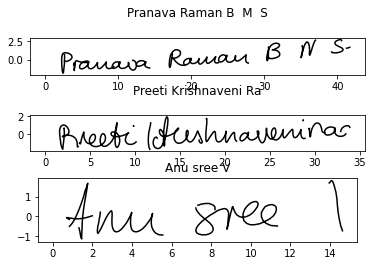

In [9]:
args.model_path = os.path.join('trained_models', 'model-29')
args.text = "sign.txt"
args.style = 7
args.info = False
args.force = False


biases = [1.0]
names = ["100"]

for i in range(len(biases)):
    args.bias=biases[i]
    args.output = "signature" + names[i] +".png"
    text = open(args.text)
    print("bias = ", args.bias)
    gen(text, args.style, args.bias, args.info, args.output)
    text.close()


bias =  1.0
INFO:tensorflow:Restoring parameters from trained_models\model-29
Line =  Pranava Raman B  M  S

[ 1038] sampling... synthesisFinished sampling!

Line =  Preeti Krishnaveni Ra

[ 1103] sampling... synthesisFinished sampling!

Line =  Anu sree V
[  735] sampling... synthesisFinished sampling!

Saving image to:  d:\ml-project-final\Machine-Learning-Project\images\multiLine\signature6100.png


<Figure size 1728x1728 with 0 Axes>

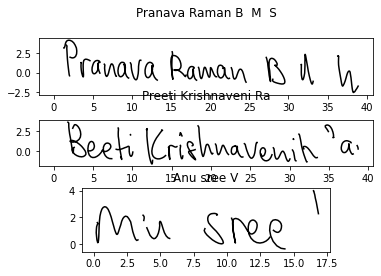

In [10]:
args.model_path = os.path.join('trained_models', 'model-29')
args.text = "sign.txt"
args.style = 6
args.info = False
args.force = False


biases = [1.0]
names = ["100"]

for i in range(len(biases)):
    args.bias=biases[i]
    args.output = "signature6" + names[i] +".png"
    text = open(args.text)
    print("bias = ", args.bias)
    gen(text, args.style, args.bias, args.info, args.output)
    text.close()
